In [1]:
import pandas as pd
import numpy as np

# Visualisation 
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import accuracy_score, confusion_matrix
import os
from datetime import datetime
import pickle

# Keras for deep learning models
from tensorflow.keras.preprocessing.text import Tokenizer  # For tokenising text data
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For sequence padding to uniform length
from tensorflow.keras.models import Sequential  # For sequential model architecture
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout  # Layers for model building
from tensorflow.keras.regularizers import l2  # L2 regularisation to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History
from tensorflow.keras.optimizers import Adam

In [2]:
def prepare_data():
    
    # Load the dataset from a CSV file
    data = pd.read_csv('car-reviews.csv')
    
    # Splitting the data into positive and negative reviews based on a predetermined index
    positive_data = data[691:]  
    negative_data = data[:691]  
    
    # Further split positive and negative datasets into training and testing subsets
    train_positive = positive_data[:553]
    test_positive = positive_data[553:] 
    train_negative = negative_data[:553]
    test_negative = negative_data[553:]  
    
    # Concatenate the positive and negative training data, and do the same for testing data
    training_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)
    testing_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)
    
    # Convert the 'Sentiment' column into a binary format: 1 for positive, 0 for negative
    training_data['Sentiment'] = np.where(training_data['Sentiment'] == 'Pos', 1, 0)
    testing_data['Sentiment'] = np.where(testing_data['Sentiment'] == 'Pos', 1, 0)

    # Extract reviews (as text) and their corresponding labels for training and testing
    training_texts = list(training_data['Review'])
    training_labels = list(training_data['Sentiment'])
    test_texts = list(testing_data['Review'])
    test_labels = list(testing_data['Sentiment'])

    # Return the processed text and labels for training and testing
    return list((training_texts, training_labels, test_texts, test_labels))

In [5]:
class LSTM_Classifier():

    model = None
    history = None
    file_id = None

    def __init__(self, data, early_stopping_patience, validation_split, tokeniser_word_count, pad_sequences_maxlen, embedding_input_dim, embedding_output_dim, 
                 lstm_unit, dropout_rate, reg_strength, epochs, batch_size, dense_output_activation_function, optimisation_model, model_loss_function):

        self.data = data
        self.early_stopping_patience = early_stopping_patience
        self.validation_split = validation_split

        self.tokeniser_word_count = tokeniser_word_count
        self.pad_sequences_maxlen = pad_sequences_maxlen

        self.embedding_input_dim = embedding_input_dim
        self.embedding_output_dim = embedding_output_dim
        self.lstm_unit = lstm_unit
        self.dropout_rate = dropout_rate
        self.reg_strength = reg_strength
        self.optimisation_model = optimisation_model
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.dense_output_activation_function = dense_output_activation_function
        self.model_loss_function = model_loss_function 


    

    
    def tokenisation(self):
        
        # Initialise the tokenizer with a maximum number of words to keep, based on word frequency
        tokenizer = Tokenizer(num_words=self.tokeniser_word_count)  # Setting the size of the vocabulary to the top 10,000 words
        tokenizer.fit_on_texts(self.data[0])  # Updates internal vocabulary based on the list of texts
        
        # Convert the list of texts to a sequence of integers
        train_sequences = tokenizer.texts_to_sequences(self.data[0])  # Transforms each text in training_texts to a sequence of integers
        self.data[0] = pad_sequences(train_sequences, maxlen=self.pad_sequences_maxlen)  # Ensures all sequences in a list have the same length by padding/truncating
        self.data[1] = np.array(self.data[1])  
        
        # Repeat the tokenisation and padding process for the testing set
        test_sequences = tokenizer.texts_to_sequences(self.data[2]) 
        self.data[2] = pad_sequences(test_sequences, maxlen=self.pad_sequences_maxlen) 
        self.data[3] = np.array(self.data[3])  


    
    

    def run_model(self):
    
        self.model = Sequential([
            
            # Input layer specifies the shape of input data = pad_sequences_maxlen
            Input(shape=(self.pad_sequences_maxlen,)),
            
            # Embedding layer to turn positive integers (indexes) into dense vectors of fixed size, 10000 is the size of the vocabulary
            Embedding(input_dim=self.embedding_input_dim, output_dim=self.embedding_output_dim),
            
            # LSTM layer with specified units and dropout for regularization
            # Wrap the LSTM layer with a Bidirectional layer
            Bidirectional(LSTM(self.lstm_unit, dropout=self.dropout_rate, recurrent_dropout=self.dropout_rate)),
            
            # Dense output layer with sigmoid activation for binary classification
            Dense(1, activation=self.dense_output_activation_function, kernel_regularizer=l2(self.reg_strength))
        ])

        
        if self.file_id is not None:
            self.load_model()
        else:
            self.train_model()

        self.evaluate_model()


    

    def train_model(self):
    
        unique_id = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save the model params and weight with the lowest validation loss and add early stopping if validation loss does not decrease for 2 epochs 
        checkpoint_filepath = os.getcwd() + f'/LSTM_Models/Weights/LSTM_Model_{unique_id}.keras'
        model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
        callbacks = [EarlyStopping(patience=self.early_stopping_patience), model_checkpoint_callback]

        self.model.compile(optimizer=self.optimisation_model, loss=self.model_loss_function, metrics=['accuracy'])
        
        # Train the model on the training data, with a validation split to monitor overfitting
        self.history = self.model.fit(self.data[0], self.data[1], batch_size=self.batch_size, epochs=self.epochs, validation_split=self.validation_split, callbacks=callbacks)

        # Save the history file
        with open(os.getcwd() + f'/LSTM_Models/histories/LSTM_History_{unique_id}.pkl', 'wb') as history_file:
            pickle.dump(self.history.history, history_file)

    

    def load_model(self):
    
        self.model.load_weights(os.getcwd() + f'/LSTM_Models/Weights/LSTM_Model_{self.file_id}.keras')
        self.model.compile(optimizer=self.optimisation_model, loss=self.model_loss_function, metrics=['accuracy'])

        with open(os.getcwd() + f'/LSTM_Models/Histories/LSTM_History_{self.file_id}.pkl', 'rb') as history_file:
            self.history = pickle.load(history_file)

        # New history with new weights - overwrites above, which loads history snapshot 
        #     self.history = self.model.fit(self.data[0], self.data[1], batch_size=self.batch_size, epochs=self.epochs, \
        #                               validation_split=self.validation_split, callbacks=[EarlyStopping(patience=self.early_stopping_patience)])

        # self.file_id = None




        
    
    def evaluate_model(self):

        # Predict probabilities on the test set and convert to class labels (1 or 0) based on a 0.5 threshold
        test_probabilities = self.model.predict(self.data[2])
        test_predictions = (test_probabilities > 0.5).astype("int32").flatten()
        
        # Generating the confusion matrix from test labels and predictions
        conf_matrix = confusion_matrix(self.data[3], test_predictions)
        conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
        print('\n')
        display(conf_matrix_df)
    
        accuracy = accuracy_score(self.data[3], test_predictions)
        print('\n')
        print('Accuracy: ', round(accuracy, 3))
        print('\n')
    
        # Call the model evaluation function to plot training history
        self.visualise_accuracy()



    
    
    def visualise_model_params(self):
        
        # Example: Visualize the weights of the first Dense layer
        dense_layer_weights = model.layers[2].get_weights()[0]  # 0 for weights, 1 for biases
        plt.hist(dense_layer_weights.flatten())
        plt.xlabel('Weight values')
        plt.ylabel('Frequency')
        plt.title('Distribution of Weight Values')
        plt.show()


    

    def visualise_accuracy(self):
        
        if self.file_id is not None:
            training_accuracy = self.history['accuracy']
            validation_accuracy = self.history['val_accuracy']
            training_loss = self.history['loss']
            validation_loss = self.history['val_loss']
        else:
            training_accuracy = self.history.history['accuracy']
            validation_accuracy = self.history.history['val_accuracy']
            training_loss = self.history.history['loss']
            validation_loss = self.history.history['val_loss']
        
        epochs = range(1, len(training_accuracy) + 1)
        
        with plt.style.context('dark_background'):
            
            plt.figure(figsize=(10, 4))
            
            # Plotting training and validation accuracy
            plt.subplot(1, 2, 1)
            plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o', color='lime')
            plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o', color='cyan')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            
            # Plotting training and validation loss
            plt.subplot(1, 2, 2)
            plt.plot(epochs, training_loss, label='Training Loss', marker='o', color='lime')
            plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', color='cyan')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            
            plt.tight_layout()
            plt.show()



    
    def run(self, file_id = None):
        self.file_id = file_id
        self.tokenisation()
        self.run_model()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step




,Predicted Negative,Predicted Positive
Actual Negative,81,57
Actual Positive,34,104




Accuracy:  0.67




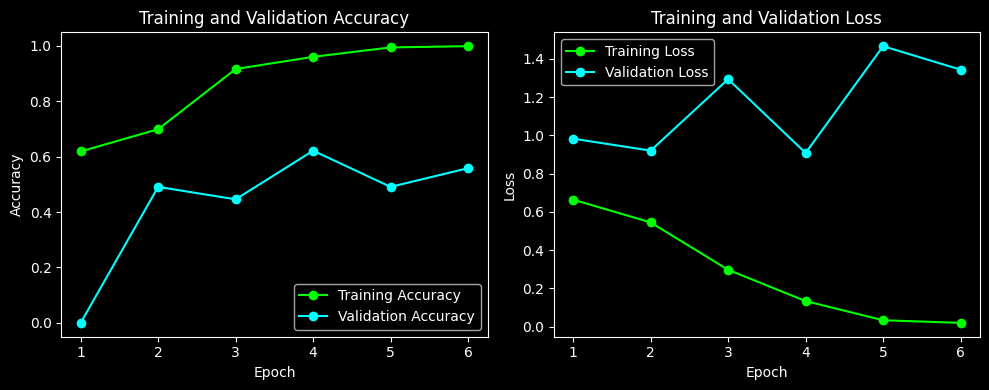

In [6]:
data = prepare_data()

lstm_classifier = LSTM_Classifier(data, 
                                  early_stopping_patience = 2,
                                  validation_split = 0.2,
                                  tokeniser_word_count = 10000,
                                  pad_sequences_maxlen = 100,
                                  embedding_input_dim = 10000,
                                  embedding_output_dim = 128,
                                  lstm_unit = 64,
                                  dropout_rate = 0.05,
                                  reg_strength = 0.0,
                                  epochs = 10,
                                  batch_size = 32,
                                  optimisation_model = 'adam',
                                  dense_output_activation_function = 'sigmoid',
                                  model_loss_function = 'binary_crossentropy',
                                 )

lstm_classifier.run('20240404_170153')

In [5]:
import optuna
from tqdm import tqdm
from optuna.samplers import RandomSampler


# Adjust Optuna verbosity
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Assuming 'data' is a list or tuple in the format [train_data, train_labels, test_data, test_labels]
# You should define 'data' appropriately before calling the optimization function

def create_model(trial):
    
    # Hyperparameters to be tuned using suggest_float for continuous and suggest_categorical for discrete
    embedding_dim = trial.suggest_categorical('embedding_dim', [64, 128, 256])
    lstm_unit = trial.suggest_categorical('lstm_unit', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    reg_strength = trial.suggest_float('reg_strength', 1e-5, 1e-1, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    
    model = Sequential([
        Embedding(input_dim=10000, output_dim=embedding_dim),
        Bidirectional(LSTM(lstm_unit, dropout=dropout_rate)),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(reg_strength))
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    history = model.fit(data[0], data[1], batch_size=32, epochs=20, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    _, accuracy = model.evaluate(data[2], data[3], verbose=0)
    return accuracy

def main():
    trials = 10
    with tqdm(total=trials, desc="Optuna Optimization") as bar:
        def optuna_progress_bar(study, trial):
            bar.update(1)
        
        # study = optuna.create_study(direction='maximize')
        study = optuna.create_study(direction='maximize', sampler=RandomSampler())
        study.optimize(objective, n_trials=trials, callbacks=[optuna_progress_bar])

    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)



main()

Optuna Optimization: 100%|█████████████████████| 10/10 [02:03<00:00, 12.36s/it]

Number of finished trials: 10
Best trial: {'embedding_dim': 64, 'lstm_unit': 128, 'dropout_rate': 0.38557398467628257, 'reg_strength': 5.475419042542701e-05, 'learning_rate': 0.0023059917664610455}


In [6]:
# Best trial: {'embedding_dim': 128, 'lstm_unit': 128, 'dropout_rate': 0.27245811158331384, 'reg_strength': 0.0015034575581423528, 'learning_rate': 0.003764332348160991}
# RS - Best trial: {'embedding_dim': 64, 'lstm_unit': 128, 'dropout_rate': 0.38557398467628257, 'reg_strength': 5.475419042542701e-05, 'learning_rate': 0.0023059917664610455}

In [ ]:

git filter-branch --force --index-filter \
"git rm --cached --ignore-unmatch -r 'Module 4 - Applications of AI/Car Reviews/LSTM_Models'" \
--prune-empty --tag-name-filter cat -- --all

Module 4 - Applications of AI/Car Reviews/LSTM_Models